# SDSS DR14 Data Classification with Neural Networks
### **Research Question:** *How does pre-training (and epochs and batches) affect the performance of a neural network?*

## **Introduction:**
This notebook investigates the impact of pre-training, epochs, and batch sizes on the performance of a neural network model to classify astronomical objects using the SDSS DR14 dataset.
The goal is to predict the 'class' of an object, as ethier a `STAR`, `GALAXY` or `QSO`, based on its features like `ra`, `dec`, `u`, `g`, `r`, `i` and `z`.

## **Data Loading and Preprocessing**
Imports the necessary libraries for data loading, preprocessing, model building, training, and evaluation.

- **Data Handling**: 
   - `pandas`: Used for data manipulation and analysis.
   - `sklearn.preprocessing`: Provides tools like `LabelEncoder` and `StandardScaler` for data preprocessing.
   - `sklearn.model_selection`: Offers functions like `train_test_split` for splitting the data into training and testing sets.
   
- **PyTorch**:
   - `torch`: The core PyTorch library for building and training models.
   - `torchvision.models`: Includes pre-trained models and utilities for deep learning.
   - `torch.utils.data`: Provides utilities like `TensorDataset` and `DataLoader` for handling data in batches.

- **Neural Network and Optimisation**:
   - `torch.nn`: Contains modules and classes to build neural network layers.
   - `torch.optim`: Provides various optimisation algorithms, including Adam.

- **Model Evaluation**:
   - `sklearn.metrics`: Includes functions like `accuracy_score`, `classification_report`, and `ConfusionMatrixDisplay` for evaluating model performance.
   - `matplotlib.pyplot`, `seaborn` and , `IPython.display`: Used for visualising and comparing the model results.

Using **PyTorch** to create the neural network model can take slightly longer to implement over other modules (e.g: **Tensorflow**), however its more naturally intuitive to use and easier to adapt for different model parameters. (To install PyTorch and TorchVison use `pip install torch torchvision`).

In [35]:
import pandas as pd                                                 # Import pandas for data manipulation
from sklearn.preprocessing import LabelEncoder, StandardScaler      # Import preprocessing tools
from sklearn.model_selection import train_test_split                # Import train-test split function
import torch                                                        # Import PyTorch for deep learning
import torchvision                                                  # Import PyTorch's torchvision for pretrained models
import torchvision.models as models                                 # Import pretrained torchvision models for deep learning
from torchvision.models import ResNet18_Weights                     # Import the weights for ResNet18
from torch.utils.data import TensorDataset, DataLoader              # Import utilities for data loading
import torch.nn as nn                                               # Import PyTorch's neural network module
import torch.optim as optim                                         # Import PyTorch's optimisation module
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay  # Import metrics for model evaluation
import matplotlib.pyplot as plt                                     # Import matplotlib for plotting
import seaborn as sns                                               # Import seaborn for plotting
from IPython.display import display                                 # Import IPython for displaying the table


**Steps:**
1. **Data Loading:** The data is loaded from a URL using `pandas.read_csv`. (*You might need to replace the URL with your own link if you're using a different data source*).
2. **Feature and Target Selection:** The relevant features (`ra`, `dec`, `u`, `g`, `r`, `i`, `z`) and the target variable (`class`) are selected.
3. **Target Encoding:** The target labels (star, galaxy, quasar) are encoded using `LabelEncoder` to convert them into numerical values (0, 1 & 2).
4. **Feature Normalization:** Features are normalized using `StandardScaler` to ensure they have zero mean and unit variance. This can improve model training.
5. **Data Splitting:** The data is split into training and testing sets using `train_test_split` with a test size of 20%.
6. **Conversion to PyTorch Tensors:** The training and testing data are converted to PyTorch tensors for use with PyTorch models.
7. **DataLoaders Creation:** `DataLoader` objects are created to efficiently feed data to the model during training and evaluation. The `batch_size` is set to 64, but this can be adjusted later.

In [36]:
# 1. Data Loading: Load the CSV file (replace with your own link if needed)
data = pd.read_csv("Skyserver_SQL2_27_2018 6_51_39 PM.csv")

# 2. Feature and Target Selection: Select features and target
features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']
target = 'class'
X = data[features]
Y = data[target]

# 3. Target Encoding: Encode target labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# 4. Feature Normalization: Normalise features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 5. Data Splitting: Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 6. Conversion to PyTorch Tensors: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# 7. DataLoaders Creation: Create DataLoaders
batch_size = 64  # to be varied this later
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

## **Model Definition**
**Steps:**
1. **Class Initialization:**
   - The class `SDSSClassifier` is initialized with parameters to configure either a pre-trained ResNet18 model or a custom feedforward network.

2. **Pre-trained ResNet18 (if `pre_trained=True`):**
   - Load a pre-trained ResNet18 model from PyTorch Hub.
   - Modify its fully connected (`fc`) layer to match the required output dimension.
   - Add a reshape layer to transform input features into a format compatible with ResNet18.

3. **Custom Feedforward Network (if `pre_trained=False`):**
   - Define a simple architecture with two linear layers and a ReLU activation function for non-linearity.

4. **Forward Method:**
   - If using the pre-trained model, reshape the input and pass it through ResNet18.
   - If using the custom model, directly pass the input through the defined feedforward layers.



In [37]:
class SDSSClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pre_trained=False):
        # 1. Initialises the SDSSClassifier model.
        """
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of units in the hidden layer for the custom model.
            output_dim (int): Number of output classes.
            pre_trained (bool): Whether to use a pre-trained model (e.g., ResNet18). Defaults to False.
        """
        super(SDSSClassifier, self).__init__()
        self.pre_trained = pre_trained

        if pre_trained:
            # 2. Use a pre-trained ResNet18 model for feature extraction
            # Load pre-trained ResNet18
            self.features = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

            # Modify the input layer for single-channel data
            self.features.conv1 = nn.Conv2d(
                in_channels=3,  # Adjust for single-channel input
                out_channels=64,
                kernel_size=(7, 7),
                stride=(2, 2),
                padding=(3, 3),
                bias=False
            )
            # Modify the final fully connected layer to match the required output dimension
            num_ftrs = self.features.fc.in_features
            self.features.fc = nn.Linear(num_ftrs, output_dim)

            # Freeze layers (freeze all except the last layer and fc)
            for param in self.features.parameters():
                param.requires_grad = False
            for param in self.features.layer4.parameters():
                param.requires_grad = True
            for param in self.features.fc.parameters():
                param.requires_grad = True

            # Add a reshape layer to transform the input into a format compatible with ResNet18
            self.reshape_layer = nn.Sequential(
                nn.Linear(input_dim, 224*224*3),  # Flatten input and match ResNet18's input size
                nn.Unflatten(1, (3, 224, 224))   # Reshape to [channels, height, width]
            )

        else:
            # 3. Define a custom feedforward neural network
            self.fc = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),  # Fully connected layer
                nn.ReLU(),                         # ReLU activation for non-linearity
                nn.Linear(hidden_dim, output_dim)  # Output layer with the desired number of classes
            )

    def forward(self, x):
        # 4. Defines the forward pass of the model.
        """
        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            torch.Tensor: Output predictions.
        """
        if self.pre_trained:
            # Reshape input for the pre-trained ResNet18 model
            x = self.reshape_layer(x)
            return self.features(x)  # Forward pass through ResNet18
        else:
            # Forward pass through the custom feedforward network
            return self.fc(x)

## **Training and Evaluation**
**Steps:**
#### For `evaluate` Function:

1. **Model Evaluation Mode:** The function starts by setting the model to evaluation mode (`model.eval()`), which disables dropout and batch normalization layers for inference.
2. **Initialization:** Two lists, `all_preds` and `all_labels`, are initialized to store predictions and true labels respectively.
3. **Inference Without Gradient Tracking:**
   - A `torch.no_grad()` block is used to disable gradient computation, improving performance during evaluation.
4. **Batch-Wise Prediction:**
   - For each batch in the `data_loader`, inputs are passed through the model to obtain outputs.
   - The `torch.max` function is used to get the predicted class for each input.
   - Predictions and labels are collected in their respective lists.
5. **Accuracy Calculation:**
   - The `accuracy_score` function is used to compute accuracy by comparing all predictions (`all_preds`) with true labels (`all_labels`).


#### For `train_and_evaluate` Function:

1. **Loss and Optimizer Initialization:**
   - The loss function is set to `CrossEntropyLoss` (suitable for classification tasks).
   - The optimizer is set to `Adam` with a learning rate of `0.001`.
2. **Tracking Metrics:**
   - Lists `train_losses` and `train_accuracies` are initialized to store per-epoch metrics.
3. **Training Loop:**
   - The model is set to training mode (`model.train()`).
   - Per-epoch, the training accuracy is calculated using the `evaluate` function and stored in `train_accuracies`.
   - The loss is calculated and accumulated for each batch, and the optimizer updates the model parameters.
   - Average loss for the epoch is computed and printed.
4. **Evaluation After Training:**
   - After training, the model is set to evaluation mode to predict on the test dataset.
   - Predictions and true labels are collected across all batches, and accuracy is calculated using `accuracy_score`.
   - A classification report and confusion matrix are generated to summarize the model’s performance.
5. **Accuracy Calculation:**
   - The `accuracy_score` function is used to compute accuracy by comparing all predictions (`all_preds`) with true labels (`all_labels`).
6. **Visualization:**
   - A confusion matrix is displayed with labels and a descriptive title showing key training parameters.


In [38]:
def evaluate(model, data_loader):
    # 1. Define the evaluate function.
    """
    This function evaluates the model's performance on a dataset.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate.

    Returns:
        float: Accuracy of the model on the given dataset.
    """
    model.eval()  # 1. Set model to evaluation mode
    all_preds = []  # 2. Initialise list to store predictions
    all_labels = []  # 2. Initialise list to store true labels

    with torch.no_grad():  # 3. Disable gradient computation for evaluation
        for inputs, labels in data_loader:  # 4. Iterate through batches
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 5. Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate=0.001):
    # 1. Define the training and evaluation function.
    """
    This function trains the model and evaluates its performance on the test set.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the test data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
        tuple: Final test accuracy, training losses, and training accuracies.
    """
    criterion = nn.CrossEntropyLoss()  # 1. Define the loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # 1. Define the optimizer

    train_losses = []  # 2. Initialise list to track training losses
    train_accuracies = []  # 2. Initialise list to track training accuracies

    for epoch in range(num_epochs):  # 3. Training loop
        model.train()  # Set model to training mode
        total_loss = 0

        train_accuracy = evaluate(model, train_loader)  # Calculate training accuracy for the epoch
        train_accuracies.append(train_accuracy)
        # 3. Batch-wise training
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))  # Store average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")
    # 4. Evaluate test data
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    # 5. Compute test accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # 6. Create and display confusion matrix
    title = f"Confusion Matrix (Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size})"  # Create title
    cm = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=label_encoder.classes_)
    plt.title(title)  # Set the title
    plt.show()
    return accuracy, train_losses, train_accuracies # Return results

## **Experimentation**
**Steps:**

1. **Experiment Setup:** Define different configurations for experiments. This includes options for whether to use a pre-trained model, the number of epochs, and the batch size. These are stored in the lists `pre_trained_options`, `epoch_options`, and `batch_size_options`.

2. **Initialization of Results Storage:** Create an empty list `results` to store the outcomes of all the experiments.

3. **Nested Loop for Experiment Combinations:**
   - A nested loop is used to iterate over all possible combinations of the settings for pre-training, epochs, and batch size.
   - The experiment settings are printed for each iteration.

4. **DataLoader Creation:**
   - For each combination of settings, `DataLoader` objects are created using the training and test tensors (`X_train_tensor`, `Y_train_tensor`, `X_test_tensor`, `Y_test_tensor`).
   - The batch size is adjusted according to the current experiment setting, and the `shuffle=True` option ensures random sampling of the training data.

5. **Model Instantiation:**
   - The input dimension is derived from the training data shape.
   - The hidden layer dimension is set to 64 (this can be adjusted if needed).
   - The output dimension corresponds to the number of classes in the label encoder.
   - A new model (`SDSSClassifier`) is instantiated with the current configuration (`pre_trained` setting).

6. **Training and Evaluation:**
   - The `train_and_evaluate` function is called to train the model and evaluate its performance on the test set for the given number of epochs.
   - The function returns the final accuracy, training losses, and training accuracies.

7. **Model Saving:** After training, the model's state dictionary (the learned parameters) is saved using `torch.save`. The file is named according to the experiment configuration (`pre_trained`, `num_epochs`, `batch_size`).

8. **Recording Results:**
   - After each experiment, the results (accuracy, training losses, and training accuracies) are appended to the `results` list for further analysis.


Running experiment: Pre-trained=False, Epochs=5, Batch Size=32
Epoch 1/5, Loss: 0.7698, Train Accuracy: 0.1148
Epoch 2/5, Loss: 0.5628, Train Accuracy: 0.7575
Epoch 3/5, Loss: 0.4903, Train Accuracy: 0.7873
Epoch 4/5, Loss: 0.4264, Train Accuracy: 0.8334
Epoch 5/5, Loss: 0.3731, Train Accuracy: 0.8739
Accuracy: 0.88
              precision    recall  f1-score   support

      GALAXY       0.92      0.87      0.89       996
         QSO       0.90      0.84      0.87       190
        STAR       0.84      0.91      0.87       814

    accuracy                           0.88      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.89      0.88      0.88      2000



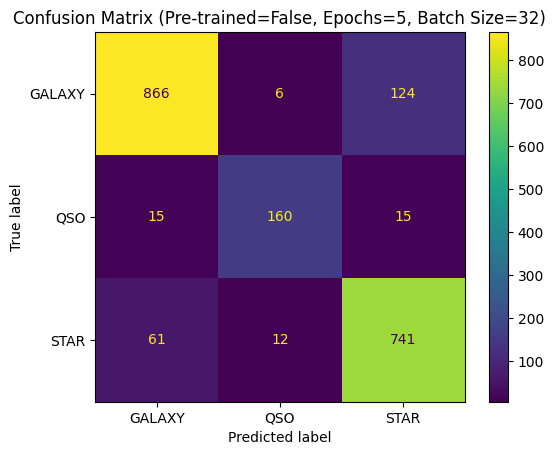

Running experiment: Pre-trained=False, Epochs=5, Batch Size=64
Epoch 1/5, Loss: 0.8399, Train Accuracy: 0.1457
Epoch 2/5, Loss: 0.6157, Train Accuracy: 0.7261
Epoch 3/5, Loss: 0.5411, Train Accuracy: 0.7662
Epoch 4/5, Loss: 0.4864, Train Accuracy: 0.7987
Epoch 5/5, Loss: 0.4394, Train Accuracy: 0.8320
Accuracy: 0.85
              precision    recall  f1-score   support

      GALAXY       0.89      0.85      0.87       996
         QSO       0.85      0.80      0.83       190
        STAR       0.81      0.87      0.84       814

    accuracy                           0.85      2000
   macro avg       0.85      0.84      0.85      2000
weighted avg       0.86      0.85      0.85      2000



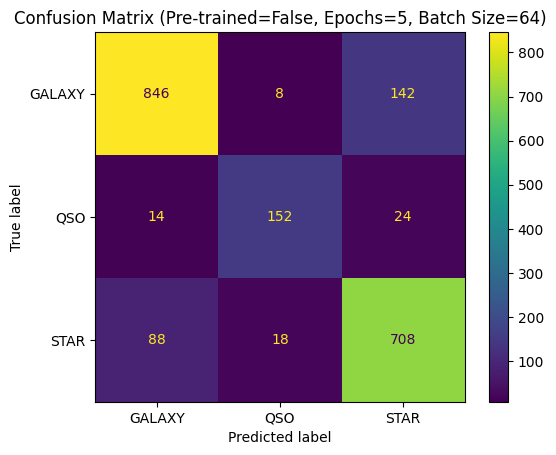

Running experiment: Pre-trained=False, Epochs=5, Batch Size=128
Epoch 1/5, Loss: 0.8976, Train Accuracy: 0.3693
Epoch 2/5, Loss: 0.6956, Train Accuracy: 0.6920
Epoch 3/5, Loss: 0.6127, Train Accuracy: 0.7455
Epoch 4/5, Loss: 0.5707, Train Accuracy: 0.7621
Epoch 5/5, Loss: 0.5402, Train Accuracy: 0.7750
Accuracy: 0.79
              precision    recall  f1-score   support

      GALAXY       0.82      0.81      0.82       996
         QSO       0.86      0.74      0.80       190
        STAR       0.74      0.77      0.76       814

    accuracy                           0.79      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.79      0.79      0.79      2000



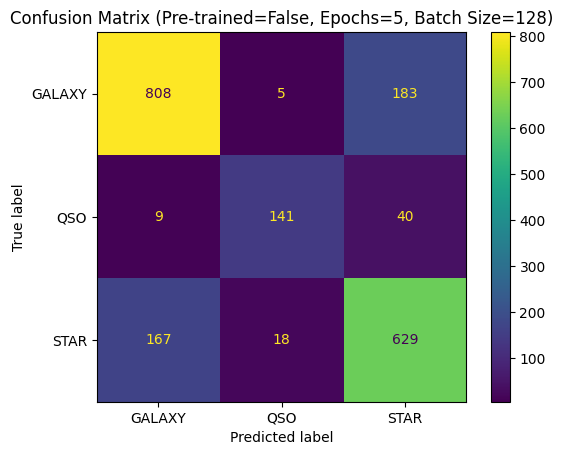

Running experiment: Pre-trained=False, Epochs=10, Batch Size=32
Epoch 1/10, Loss: 0.7048, Train Accuracy: 0.5006
Epoch 2/10, Loss: 0.5476, Train Accuracy: 0.7561
Epoch 3/10, Loss: 0.4803, Train Accuracy: 0.7961
Epoch 4/10, Loss: 0.4171, Train Accuracy: 0.8380
Epoch 5/10, Loss: 0.3679, Train Accuracy: 0.8704
Epoch 6/10, Loss: 0.3330, Train Accuracy: 0.9010
Epoch 7/10, Loss: 0.3117, Train Accuracy: 0.9146
Epoch 8/10, Loss: 0.2973, Train Accuracy: 0.9210
Epoch 9/10, Loss: 0.2881, Train Accuracy: 0.9277
Epoch 10/10, Loss: 0.2810, Train Accuracy: 0.9284
Accuracy: 0.93
              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94       996
         QSO       0.92      0.87      0.90       190
        STAR       0.89      0.97      0.93       814

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



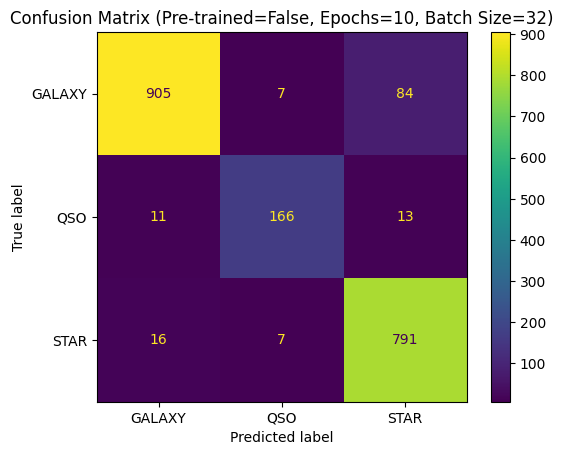

Running experiment: Pre-trained=False, Epochs=10, Batch Size=64
Epoch 1/10, Loss: 0.8051, Train Accuracy: 0.5110
Epoch 2/10, Loss: 0.6123, Train Accuracy: 0.7139
Epoch 3/10, Loss: 0.5448, Train Accuracy: 0.7686
Epoch 4/10, Loss: 0.4961, Train Accuracy: 0.7880
Epoch 5/10, Loss: 0.4469, Train Accuracy: 0.8220
Epoch 6/10, Loss: 0.4025, Train Accuracy: 0.8538
Epoch 7/10, Loss: 0.3677, Train Accuracy: 0.8800
Epoch 8/10, Loss: 0.3428, Train Accuracy: 0.8949
Epoch 9/10, Loss: 0.3242, Train Accuracy: 0.9051
Epoch 10/10, Loss: 0.3117, Train Accuracy: 0.9143
Accuracy: 0.92
              precision    recall  f1-score   support

      GALAXY       0.95      0.90      0.92       996
         QSO       0.93      0.85      0.89       190
        STAR       0.88      0.95      0.91       814

    accuracy                           0.92      2000
   macro avg       0.92      0.90      0.91      2000
weighted avg       0.92      0.92      0.92      2000



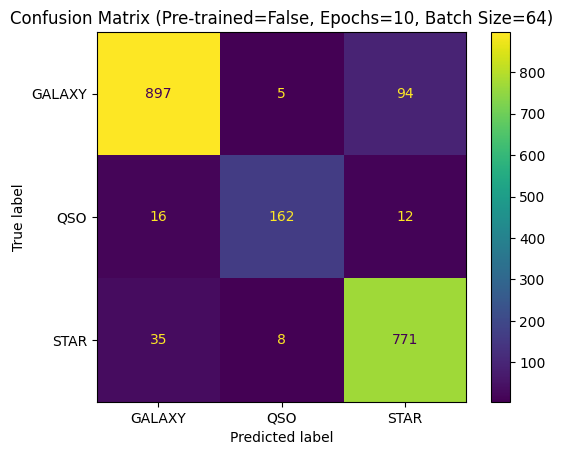

Running experiment: Pre-trained=False, Epochs=10, Batch Size=128
Epoch 1/10, Loss: 0.8768, Train Accuracy: 0.4688
Epoch 2/10, Loss: 0.6882, Train Accuracy: 0.7110
Epoch 3/10, Loss: 0.6143, Train Accuracy: 0.7420
Epoch 4/10, Loss: 0.5756, Train Accuracy: 0.7621
Epoch 5/10, Loss: 0.5420, Train Accuracy: 0.7759
Epoch 6/10, Loss: 0.5119, Train Accuracy: 0.7889
Epoch 7/10, Loss: 0.4815, Train Accuracy: 0.8051
Epoch 8/10, Loss: 0.4526, Train Accuracy: 0.8251
Epoch 9/10, Loss: 0.4234, Train Accuracy: 0.8446
Epoch 10/10, Loss: 0.3980, Train Accuracy: 0.8608
Accuracy: 0.87
              precision    recall  f1-score   support

      GALAXY       0.90      0.87      0.88       996
         QSO       0.89      0.83      0.86       190
        STAR       0.83      0.89      0.86       814

    accuracy                           0.87      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.87      0.87      0.87      2000



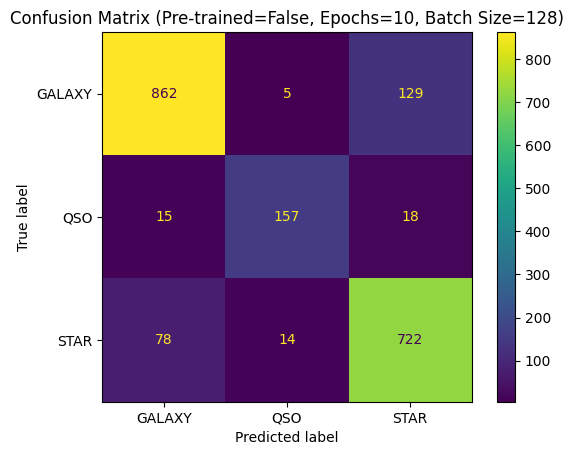

Running experiment: Pre-trained=False, Epochs=20, Batch Size=32
Epoch 1/20, Loss: 0.7391, Train Accuracy: 0.3533
Epoch 2/20, Loss: 0.5334, Train Accuracy: 0.7632
Epoch 3/20, Loss: 0.4529, Train Accuracy: 0.8074
Epoch 4/20, Loss: 0.3895, Train Accuracy: 0.8529
Epoch 5/20, Loss: 0.3477, Train Accuracy: 0.8839
Epoch 6/20, Loss: 0.3204, Train Accuracy: 0.9069
Epoch 7/20, Loss: 0.3037, Train Accuracy: 0.9126
Epoch 8/20, Loss: 0.2908, Train Accuracy: 0.9195
Epoch 9/20, Loss: 0.2831, Train Accuracy: 0.9246
Epoch 10/20, Loss: 0.2776, Train Accuracy: 0.9256
Epoch 11/20, Loss: 0.2724, Train Accuracy: 0.9293
Epoch 12/20, Loss: 0.2689, Train Accuracy: 0.9301
Epoch 13/20, Loss: 0.2654, Train Accuracy: 0.9307
Epoch 14/20, Loss: 0.2626, Train Accuracy: 0.9325
Epoch 15/20, Loss: 0.2604, Train Accuracy: 0.9337
Epoch 16/20, Loss: 0.2584, Train Accuracy: 0.9366
Epoch 17/20, Loss: 0.2562, Train Accuracy: 0.9357
Epoch 18/20, Loss: 0.2546, Train Accuracy: 0.9346
Epoch 19/20, Loss: 0.2531, Train Accuracy: 0.

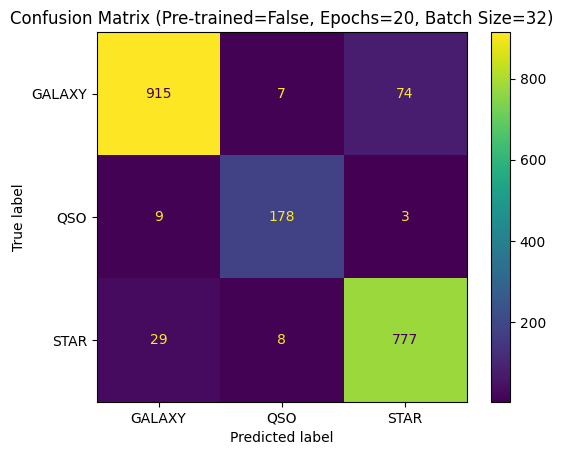

Running experiment: Pre-trained=False, Epochs=20, Batch Size=64
Epoch 1/20, Loss: 0.8027, Train Accuracy: 0.4170
Epoch 2/20, Loss: 0.6080, Train Accuracy: 0.7402
Epoch 3/20, Loss: 0.5505, Train Accuracy: 0.7566
Epoch 4/20, Loss: 0.5054, Train Accuracy: 0.7831
Epoch 5/20, Loss: 0.4618, Train Accuracy: 0.8096
Epoch 6/20, Loss: 0.4209, Train Accuracy: 0.8399
Epoch 7/20, Loss: 0.3852, Train Accuracy: 0.8625
Epoch 8/20, Loss: 0.3561, Train Accuracy: 0.8838
Epoch 9/20, Loss: 0.3346, Train Accuracy: 0.9022
Epoch 10/20, Loss: 0.3181, Train Accuracy: 0.9104
Epoch 11/20, Loss: 0.3079, Train Accuracy: 0.9144
Epoch 12/20, Loss: 0.2990, Train Accuracy: 0.9194
Epoch 13/20, Loss: 0.2920, Train Accuracy: 0.9234
Epoch 14/20, Loss: 0.2870, Train Accuracy: 0.9264
Epoch 15/20, Loss: 0.2816, Train Accuracy: 0.9281
Epoch 16/20, Loss: 0.2775, Train Accuracy: 0.9284
Epoch 17/20, Loss: 0.2745, Train Accuracy: 0.9277
Epoch 18/20, Loss: 0.2713, Train Accuracy: 0.9283
Epoch 19/20, Loss: 0.2698, Train Accuracy: 0.

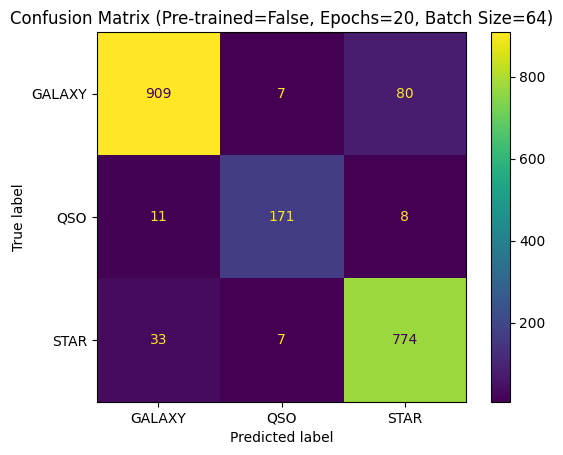

Running experiment: Pre-trained=False, Epochs=20, Batch Size=128
Epoch 1/20, Loss: 0.8834, Train Accuracy: 0.3553
Epoch 2/20, Loss: 0.6922, Train Accuracy: 0.6797
Epoch 3/20, Loss: 0.6168, Train Accuracy: 0.7410
Epoch 4/20, Loss: 0.5750, Train Accuracy: 0.7596
Epoch 5/20, Loss: 0.5448, Train Accuracy: 0.7745
Epoch 6/20, Loss: 0.5129, Train Accuracy: 0.7866
Epoch 7/20, Loss: 0.4816, Train Accuracy: 0.8046
Epoch 8/20, Loss: 0.4544, Train Accuracy: 0.8233
Epoch 9/20, Loss: 0.4272, Train Accuracy: 0.8420
Epoch 10/20, Loss: 0.4020, Train Accuracy: 0.8555
Epoch 11/20, Loss: 0.3804, Train Accuracy: 0.8745
Epoch 12/20, Loss: 0.3615, Train Accuracy: 0.8864
Epoch 13/20, Loss: 0.3456, Train Accuracy: 0.8916
Epoch 14/20, Loss: 0.3317, Train Accuracy: 0.9071
Epoch 15/20, Loss: 0.3226, Train Accuracy: 0.9120
Epoch 16/20, Loss: 0.3112, Train Accuracy: 0.9147
Epoch 17/20, Loss: 0.3048, Train Accuracy: 0.9206
Epoch 18/20, Loss: 0.2999, Train Accuracy: 0.9210
Epoch 19/20, Loss: 0.2932, Train Accuracy: 0

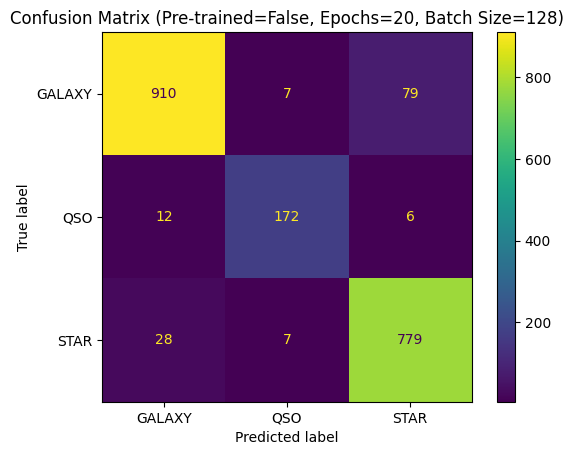

Running experiment: Pre-trained=True, Epochs=5, Batch Size=32
Epoch 1/5, Loss: 0.7217, Train Accuracy: 0.4654
Epoch 2/5, Loss: 0.5509, Train Accuracy: 0.7510
Epoch 3/5, Loss: 0.4758, Train Accuracy: 0.7976
Epoch 4/5, Loss: 0.4097, Train Accuracy: 0.8409
Epoch 5/5, Loss: 0.3598, Train Accuracy: 0.8708
Accuracy: 0.90
              precision    recall  f1-score   support

      GALAXY       0.93      0.89      0.91       996
         QSO       0.91      0.83      0.87       190
        STAR       0.86      0.93      0.90       814

    accuracy                           0.90      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.90      0.90      0.90      2000



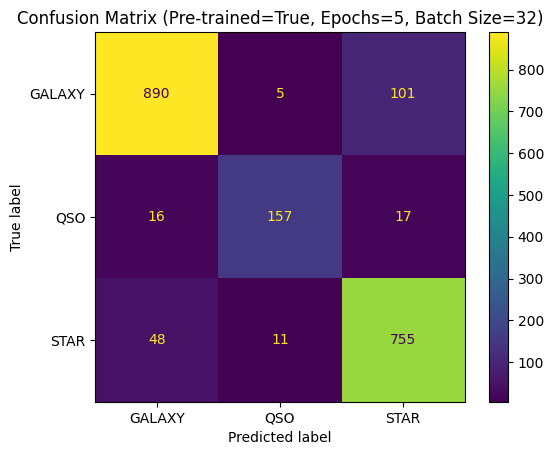

Running experiment: Pre-trained=True, Epochs=5, Batch Size=64
Epoch 1/5, Loss: 0.8135, Train Accuracy: 0.3683
Epoch 2/5, Loss: 0.6174, Train Accuracy: 0.7216
Epoch 3/5, Loss: 0.5515, Train Accuracy: 0.7630
Epoch 4/5, Loss: 0.5051, Train Accuracy: 0.7876
Epoch 5/5, Loss: 0.4587, Train Accuracy: 0.8105
Accuracy: 0.85
              precision    recall  f1-score   support

      GALAXY       0.89      0.84      0.86       996
         QSO       0.84      0.83      0.84       190
        STAR       0.80      0.86      0.83       814

    accuracy                           0.85      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.85      0.85      2000



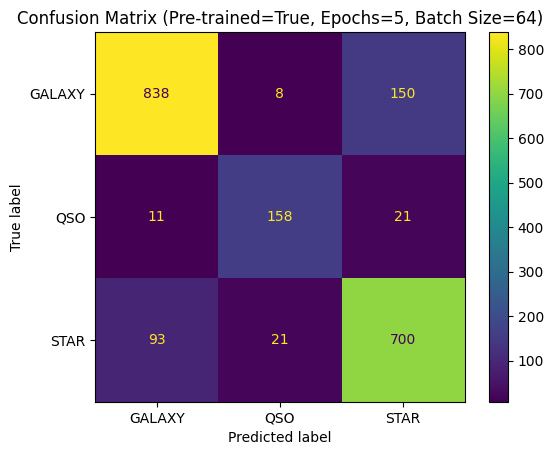

Running experiment: Pre-trained=True, Epochs=5, Batch Size=128
Epoch 1/5, Loss: 0.8915, Train Accuracy: 0.3952
Epoch 2/5, Loss: 0.7086, Train Accuracy: 0.7090
Epoch 3/5, Loss: 0.6215, Train Accuracy: 0.7444
Epoch 4/5, Loss: 0.5763, Train Accuracy: 0.7519
Epoch 5/5, Loss: 0.5450, Train Accuracy: 0.7702
Accuracy: 0.78
              precision    recall  f1-score   support

      GALAXY       0.82      0.82      0.82       996
         QSO       0.85      0.64      0.73       190
        STAR       0.73      0.77      0.75       814

    accuracy                           0.78      2000
   macro avg       0.80      0.74      0.77      2000
weighted avg       0.79      0.78      0.78      2000



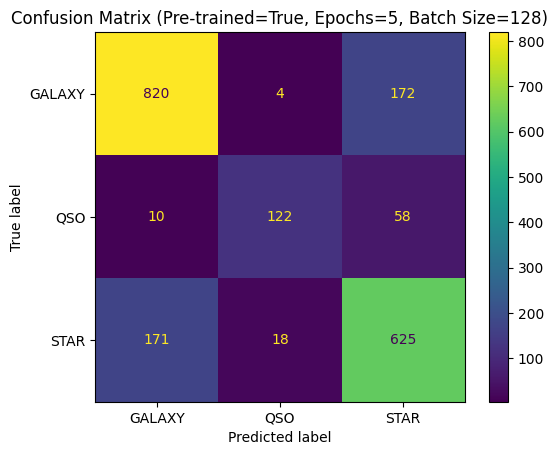

Running experiment: Pre-trained=True, Epochs=10, Batch Size=32
Epoch 1/10, Loss: 0.7527, Train Accuracy: 0.3089
Epoch 2/10, Loss: 0.5492, Train Accuracy: 0.7595
Epoch 3/10, Loss: 0.4722, Train Accuracy: 0.8005
Epoch 4/10, Loss: 0.4024, Train Accuracy: 0.8449
Epoch 5/10, Loss: 0.3521, Train Accuracy: 0.8845
Epoch 6/10, Loss: 0.3200, Train Accuracy: 0.9036
Epoch 7/10, Loss: 0.3013, Train Accuracy: 0.9143
Epoch 8/10, Loss: 0.2882, Train Accuracy: 0.9219
Epoch 9/10, Loss: 0.2797, Train Accuracy: 0.9291
Epoch 10/10, Loss: 0.2734, Train Accuracy: 0.9275
Accuracy: 0.93
              precision    recall  f1-score   support

      GALAXY       0.96      0.91      0.94       996
         QSO       0.91      0.92      0.91       190
        STAR       0.90      0.96      0.93       814

    accuracy                           0.93      2000
   macro avg       0.92      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



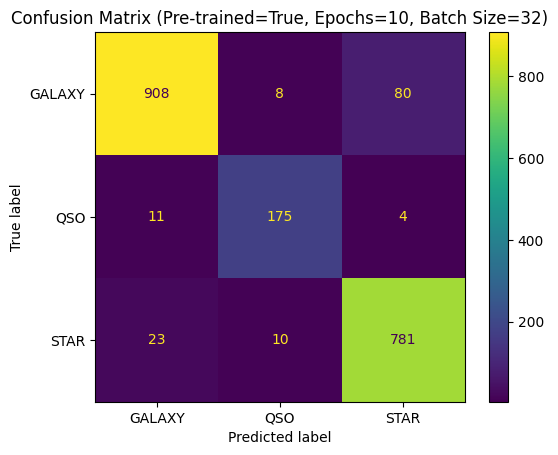

Running experiment: Pre-trained=True, Epochs=10, Batch Size=64
Epoch 1/10, Loss: 0.8298, Train Accuracy: 0.4094
Epoch 2/10, Loss: 0.6022, Train Accuracy: 0.7540
Epoch 3/10, Loss: 0.5315, Train Accuracy: 0.7778
Epoch 4/10, Loss: 0.4846, Train Accuracy: 0.8007
Epoch 5/10, Loss: 0.4432, Train Accuracy: 0.8213
Epoch 6/10, Loss: 0.4055, Train Accuracy: 0.8499
Epoch 7/10, Loss: 0.3747, Train Accuracy: 0.8678
Epoch 8/10, Loss: 0.3509, Train Accuracy: 0.8886
Epoch 9/10, Loss: 0.3326, Train Accuracy: 0.8988
Epoch 10/10, Loss: 0.3192, Train Accuracy: 0.9074
Accuracy: 0.91
              precision    recall  f1-score   support

      GALAXY       0.94      0.90      0.92       996
         QSO       0.91      0.82      0.86       190
        STAR       0.87      0.94      0.90       814

    accuracy                           0.91      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.91      0.91      0.91      2000



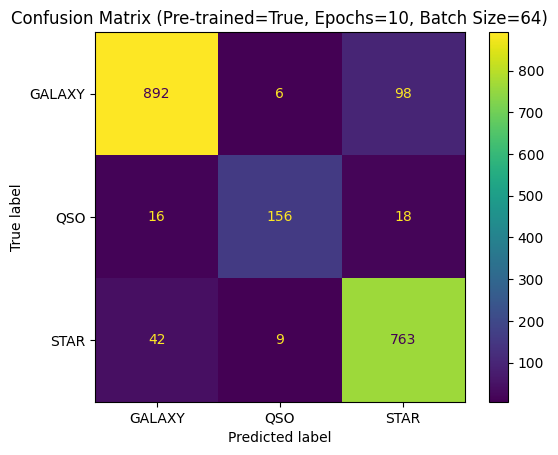

Running experiment: Pre-trained=True, Epochs=10, Batch Size=128
Epoch 1/10, Loss: 0.8798, Train Accuracy: 0.4961
Epoch 2/10, Loss: 0.6997, Train Accuracy: 0.7161
Epoch 3/10, Loss: 0.6203, Train Accuracy: 0.7425
Epoch 4/10, Loss: 0.5739, Train Accuracy: 0.7578
Epoch 5/10, Loss: 0.5395, Train Accuracy: 0.7734
Epoch 6/10, Loss: 0.5080, Train Accuracy: 0.7894
Epoch 7/10, Loss: 0.4771, Train Accuracy: 0.8105
Epoch 8/10, Loss: 0.4477, Train Accuracy: 0.8310
Epoch 9/10, Loss: 0.4200, Train Accuracy: 0.8474
Epoch 10/10, Loss: 0.3954, Train Accuracy: 0.8682
Accuracy: 0.87
              precision    recall  f1-score   support

      GALAXY       0.91      0.86      0.88       996
         QSO       0.88      0.83      0.85       190
        STAR       0.83      0.89      0.86       814

    accuracy                           0.87      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.87      0.87      2000



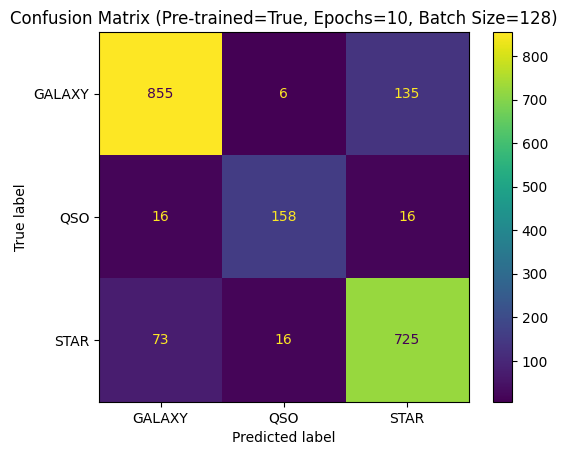

Running experiment: Pre-trained=True, Epochs=20, Batch Size=32
Epoch 1/20, Loss: 0.7166, Train Accuracy: 0.4505
Epoch 2/20, Loss: 0.5267, Train Accuracy: 0.7724
Epoch 3/20, Loss: 0.4534, Train Accuracy: 0.8046
Epoch 4/20, Loss: 0.3893, Train Accuracy: 0.8526
Epoch 5/20, Loss: 0.3458, Train Accuracy: 0.8905
Epoch 6/20, Loss: 0.3187, Train Accuracy: 0.9107
Epoch 7/20, Loss: 0.3017, Train Accuracy: 0.9161
Epoch 8/20, Loss: 0.2906, Train Accuracy: 0.9224
Epoch 9/20, Loss: 0.2830, Train Accuracy: 0.9290
Epoch 10/20, Loss: 0.2779, Train Accuracy: 0.9294
Epoch 11/20, Loss: 0.2737, Train Accuracy: 0.9329
Epoch 12/20, Loss: 0.2690, Train Accuracy: 0.9326
Epoch 13/20, Loss: 0.2662, Train Accuracy: 0.9337
Epoch 14/20, Loss: 0.2641, Train Accuracy: 0.9364
Epoch 15/20, Loss: 0.2619, Train Accuracy: 0.9353
Epoch 16/20, Loss: 0.2601, Train Accuracy: 0.9365
Epoch 17/20, Loss: 0.2588, Train Accuracy: 0.9357
Epoch 18/20, Loss: 0.2576, Train Accuracy: 0.9380
Epoch 19/20, Loss: 0.2551, Train Accuracy: 0.9

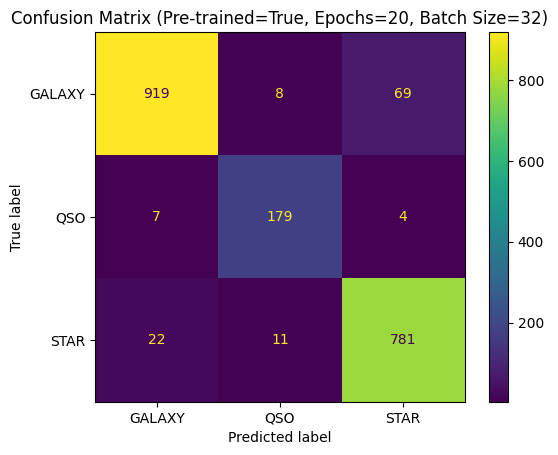

Running experiment: Pre-trained=True, Epochs=20, Batch Size=64
Epoch 1/20, Loss: 0.8077, Train Accuracy: 0.3493
Epoch 2/20, Loss: 0.5999, Train Accuracy: 0.7489
Epoch 3/20, Loss: 0.5458, Train Accuracy: 0.7682
Epoch 4/20, Loss: 0.5059, Train Accuracy: 0.7840
Epoch 5/20, Loss: 0.4662, Train Accuracy: 0.8083
Epoch 6/20, Loss: 0.4283, Train Accuracy: 0.8307
Epoch 7/20, Loss: 0.3918, Train Accuracy: 0.8568
Epoch 8/20, Loss: 0.3626, Train Accuracy: 0.8759
Epoch 9/20, Loss: 0.3406, Train Accuracy: 0.8938
Epoch 10/20, Loss: 0.3236, Train Accuracy: 0.9034
Epoch 11/20, Loss: 0.3108, Train Accuracy: 0.9120
Epoch 12/20, Loss: 0.3013, Train Accuracy: 0.9175
Epoch 13/20, Loss: 0.2935, Train Accuracy: 0.9187
Epoch 14/20, Loss: 0.2877, Train Accuracy: 0.9233
Epoch 15/20, Loss: 0.2830, Train Accuracy: 0.9263
Epoch 16/20, Loss: 0.2786, Train Accuracy: 0.9263
Epoch 17/20, Loss: 0.2768, Train Accuracy: 0.9273
Epoch 18/20, Loss: 0.2731, Train Accuracy: 0.9305
Epoch 19/20, Loss: 0.2701, Train Accuracy: 0.9

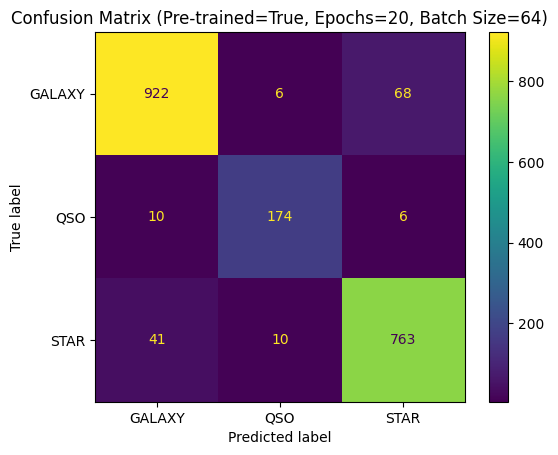

Running experiment: Pre-trained=True, Epochs=20, Batch Size=128
Epoch 1/20, Loss: 0.9263, Train Accuracy: 0.1760
Epoch 2/20, Loss: 0.7119, Train Accuracy: 0.7039
Epoch 3/20, Loss: 0.6121, Train Accuracy: 0.7411
Epoch 4/20, Loss: 0.5584, Train Accuracy: 0.7659
Epoch 5/20, Loss: 0.5167, Train Accuracy: 0.7889
Epoch 6/20, Loss: 0.4857, Train Accuracy: 0.8021
Epoch 7/20, Loss: 0.4572, Train Accuracy: 0.8246
Epoch 8/20, Loss: 0.4297, Train Accuracy: 0.8406
Epoch 9/20, Loss: 0.4049, Train Accuracy: 0.8554
Epoch 10/20, Loss: 0.3800, Train Accuracy: 0.8738
Epoch 11/20, Loss: 0.3597, Train Accuracy: 0.8844
Epoch 12/20, Loss: 0.3444, Train Accuracy: 0.8935
Epoch 13/20, Loss: 0.3283, Train Accuracy: 0.9028
Epoch 14/20, Loss: 0.3160, Train Accuracy: 0.9103
Epoch 15/20, Loss: 0.3085, Train Accuracy: 0.9169
Epoch 16/20, Loss: 0.3027, Train Accuracy: 0.9191
Epoch 17/20, Loss: 0.2970, Train Accuracy: 0.9196
Epoch 18/20, Loss: 0.2899, Train Accuracy: 0.9237
Epoch 19/20, Loss: 0.2852, Train Accuracy: 0.

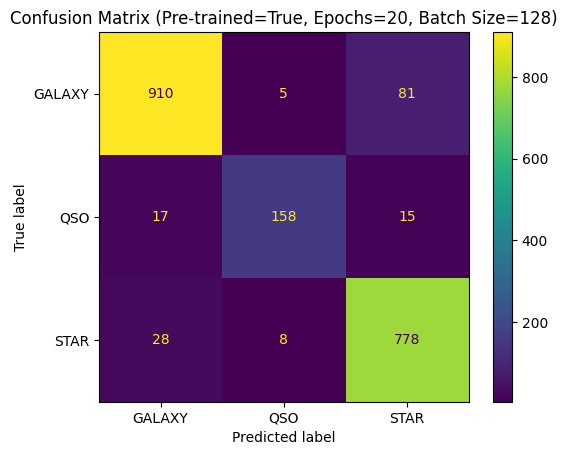

In [ ]:
# 1. Experiment with different settings
pre_trained_options = [False, True]  # Define pre-training options: with and without pre-training
epoch_options = [5, 10, 20]  # Define different numbers of training epochs
batch_size_options = [32, 64, 128]  # Define batch size options

results = []  # 2. Initialise a list to store experiment results

# 3. Nested loops for experiments with all combinations of settings
for pre_trained in pre_trained_options:
    for num_epochs in epoch_options:
        for batch_size in batch_size_options:
            print(f"Running experiment: Pre-trained={pre_trained}, Epochs={num_epochs}, Batch Size={batch_size}")

            # 4. Create DataLoader with current batch size
            train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

            # 5. Instantiate and configure the model
            input_dim = X_train.shape[1]  # Input dimension from dataset
            hidden_dim = 64  # Hidden layer size (adjustable)
            output_dim = len(label_encoder.classes_)  # Number of output classes
            model = SDSSClassifier(input_dim, hidden_dim, output_dim, pre_trained=pre_trained)  # Create the model

            # 6. Train and evaluate the model
            accuracy, train_losses, train_accuracies = train_and_evaluate(model, train_loader, test_loader, num_epochs)

            # 7. Save the model's state dictionary to a file
            torch.save(model.state_dict(), f"model_{pre_trained}_{num_epochs}_{batch_size}.pth")

            # 8. Record the results of the experiment
            results.append({
                'pre_trained': pre_trained,
                'epochs': num_epochs,
                'batch_size': batch_size,
                'accuracy': accuracy,  # Store final accuracy
                'train_losses': train_losses,  # Store training losses
                'train_accuracies': train_accuracies  # Store training accuracies
            })

## **Results:**

In [40]:
results_df = pd.DataFrame(results)

# Extract final loss from train_losses
results_df['final_loss'] = results_df['train_losses'].apply(lambda x: x[-1])

# Add a 'Model' column starting from 1
results_df['Model'] = range(1, len(results_df) + 1)

# Select desired columns and reorder
results_df = results_df[['Model', 'pre_trained', 'epochs', 'batch_size', 'accuracy', 'final_loss']]

# Style the table to highlight the best accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=['accuracy'])

# Sort by accuracy in descending order (not displayed, but you might want it)
#sorted_df = results_df.sort_values(by='accuracy', ascending=False)

# Adjust table width for better readability
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt')]},{'selector': 'td', 'props': [('font-size', '12pt')]},{'selector': 'th.col_heading', 'props': [('text-align', 'center')]},{'selector': 'th.row_heading', 'props': [('text-align', 'right')]},{'selector': '', 'props': [('width', '1000px')]}]).hide(axis="index")  # hide the index column for cleaner look

# Display the styled and sorted table
display(styled_df)

Model,pre_trained,epochs,batch_size,accuracy,final_loss
1,False,5,32,0.883500,0.373052
2,False,5,64,0.853000,0.439403
3,False,5,128,0.789000,0.540189
4,False,10,32,0.931000,0.281026
5,False,10,64,0.915000,0.311738
6,False,10,128,0.870500,0.398041
7,False,20,32,0.935000,0.250535
8,False,20,64,0.927000,0.267332
9,False,20,128,0.930500,0.293307
10,True,5,32,0.901000,0.359787


## **Impact of Batch Size on Model Accuracy:**

Batch size is a crucial hyperparameter in training neural networks. It determines the number of data samples processed before updating the model's weights. Choosing the right batch size can significantly influence the model's accuracy and training efficiency.

However, there are fundamental trade-off between using smaller and larger batch sizes:

**Smaller Batch Sizes (e.g., 32, 64):**

* **Advantages:**
    * **Improved Generalisation:** Introduce more noise during training, helping the model escape local minima and potentially leading to better performance on unseen data (higher accuracy on the test set).
    * **Regularisation Effect:** Act as a form of regularisation, reducing overfitting.

* **Disadvantages:**
    * **Slower Training:** Require more frequent weight updates, resulting in slower training times per epoch.
    * **Noisy Updates:** Weight updates can be more erratic between epoch due to the smaller, less representative sample of data used in each update.

**Larger Batch Sizes (e.g., 128, 256):**

* **Advantages:**
    * **Faster Training:** Takes advantage of parallel processing, leading to faster training time per epoch.
    * **Stable Updates:** Weight updates are more stable due to a more accurate estimate of the gradient.

* **Disadvantages:**
    * **Reduced Generalisation:** May make the model more prone to getting stuck in local minima, potentially resulting in lower accuracy on the test set.
    * **Higher Memory Requirements:** Can require more memory, especially with large datasets and more complex models.

**Finding the Optimal Batch Size:**

There's no one-size-fits-all answer for the best batch size so experimentation is key! The ideal choice depends on the specific dataset, model architecture, and available computational resources.

In this project, we experiment with batch sizes of 32, 64, and 128. The results show that a batch size of 32 gives the highest accuracy and that higher batch sizes have a proportionately negative impact on accuracy. The pretrained models also followed this trend very well, particularly favouring the batch size of 32 Our optimum batch size of 32 also proves to create the most consistancy between different models, showing the lowest deviation in prediction accuracies accross all models.

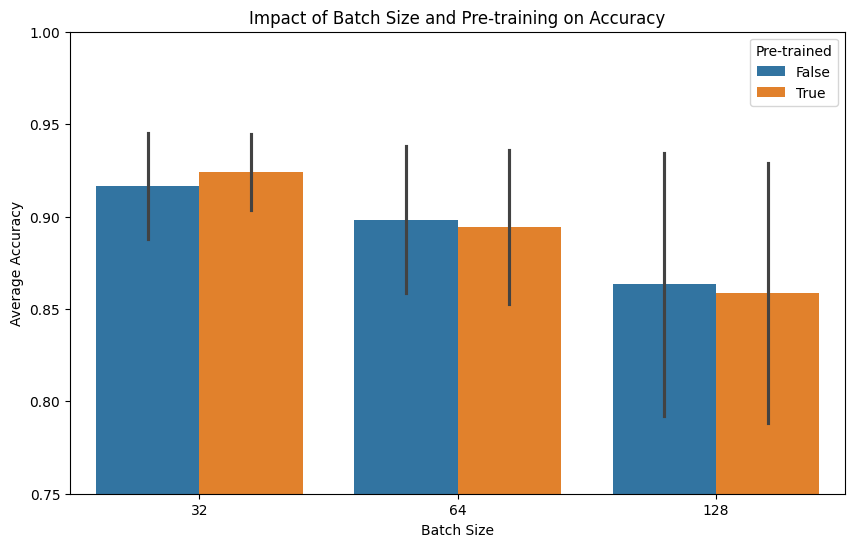

In [41]:
# Bar plot with error bars, grouped by pre-training
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='batch_size', y='accuracy', hue='pre_trained', data=results_df, errorbar='sd')
plt.ylim(0.75, 1.0)
plt.xlabel('Batch Size')
plt.ylabel('Average Accuracy')
plt.title('Impact of Batch Size and Pre-training on Accuracy')
plt.legend(title="Pre-trained")
plt.show()

## **Training Loss Against Epochs:**

Training loss is a measure of how well your model is fitting the training data. It represents the difference between the model's predictions and the actual target values. A lower training loss generally indicates that the model is learning and improving its ability to predict the correct output.

**Relationship with Epochs:**

- **General Trend:** As the number of epochs increases, the training loss typically decreases. This is because the model has more opportunities to adjust its weights and biases to better fit the training data.
- **Convergence:** Ideally, the training loss will gradually decrease and eventually plateau, indicating that the model has converged and further training might not lead to significant improvements.
- **Overfitting:** If the training loss continues to decrease significantly while the validation loss starts to increase, it might be a sign of overfitting. Overfitting occurs when the model learns the training data too well and starts to memorize it, leading to poor performance on unseen data.


In this project, experimentation shows all models have decreased loss with increasing epochs, highlighting the models increased ability to fit to the data with each epoch. The plot also suggests that all the models tested would not be prone to significant overfitting, however only the `epoch=20` model begin to converge closer to stability.

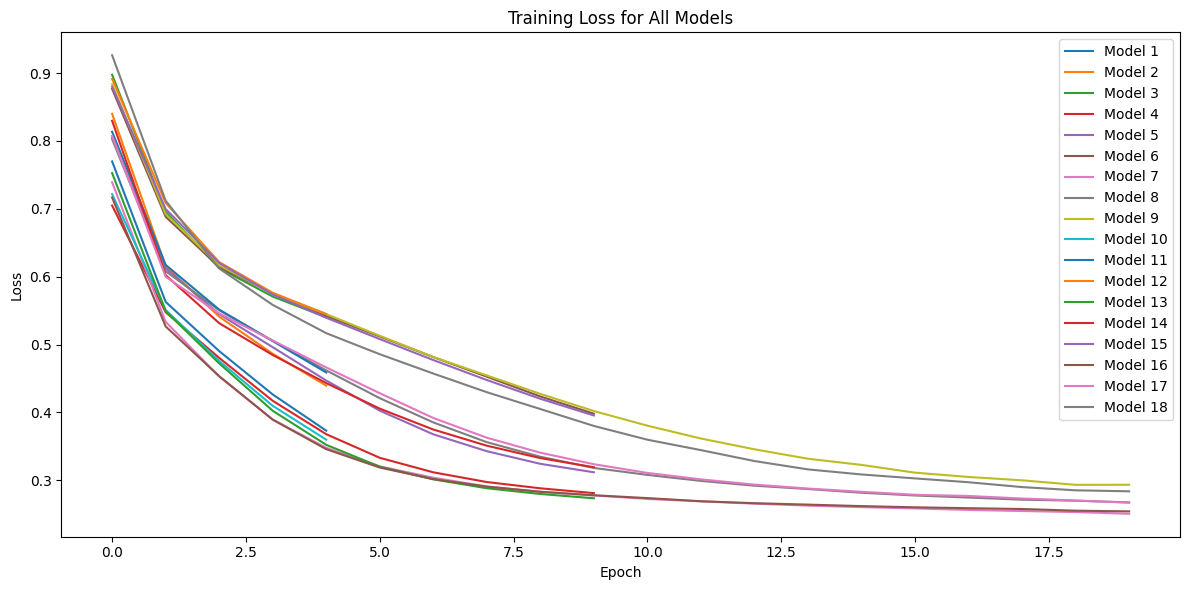

In [42]:
# --- Loss Plot ---
fig1, ax1 = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    ax1.plot(result['train_losses'], label=f"Model {i+1}", color=f'C{i}')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss for All Models")
ax1.legend()
plt.tight_layout()
plt.show()

## **Accuracy Against Epochs:**

Accuracy is pherhaps the most important metric used to evaluate the performance of a classification model. It represents the percentage of correctly classified instances in a dataset. Higher accuracy indicates better model performance.

**Relationship with Epochs:**

- **General Trend:** As the number of epochs increases, the accuracy on the training set typically increases. This is because the model is learning to make better predictions, with each epoch, as it sees more data and updates its weights.
- **Early Stopping:** Monitoring the accuracy helps decide when to stop training to prevent overfitting. You might stop training when the accuracy starts to decrease or stops improving significantly.

In this project, all models show increasing prediction accuracy with increasing epochs. The higher epoch models also converge to a maximum accuracy without sudden decreases, also suggesting minimal overfitting.

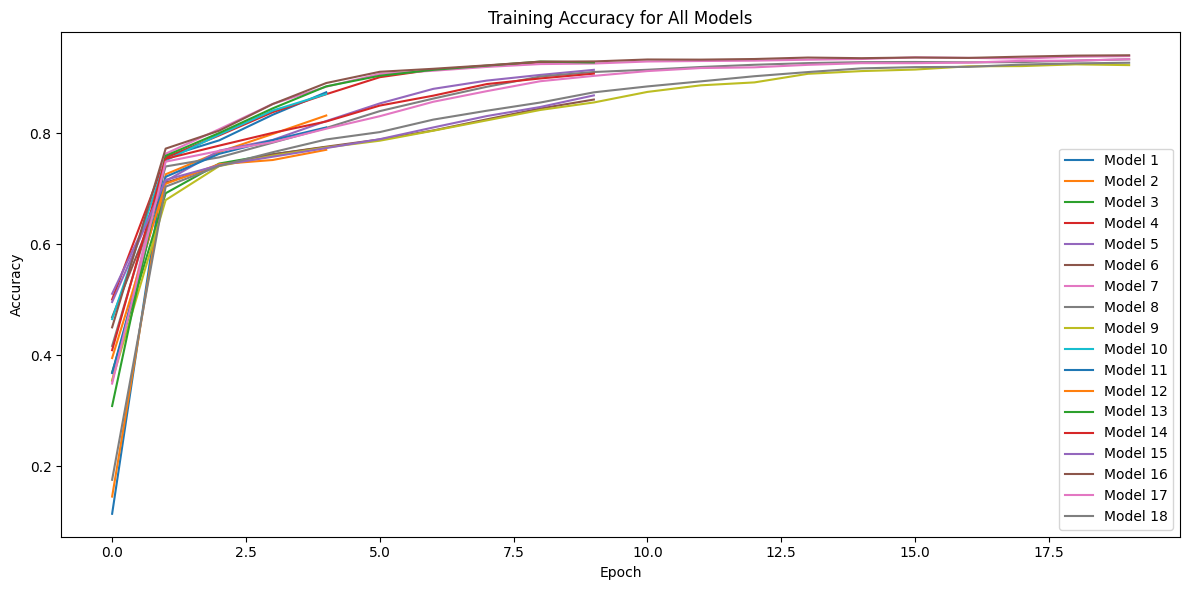

In [ ]:
# --- Accuracy Plot ---
fig2, ax2 = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    ax2.plot(result['train_accuracies'], label=f"Model {i+1}", color=f'C{i}')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training Accuracy for All Models")
ax2.legend()
plt.tight_layout()
plt.show()

## **Accuracy Against Final Loss:**
By examining the relationship between the final training loss and the achieved accuracy, we can draw conclusions about the overall performance and convergence of the models under different experimental settings. This analysis can ultimately select the most suitable model for the given classification task.

**Key Observations:**

* **General Trend:** The graph generally shows a negative correlation between accuracy and final loss. This is expected, as models with lower final loss values tend to have higher accuracy, indicating better performance.
* **Model Comparison:** The plot allows us to visually compare the performance of different models. Models clustered towards the top left corner (low loss, high accuracy) represent the best-performing models.

In this project, we clearly see a negative correlation between accuracy and final loss, with model 16 consistantly the best performing. The lower loss cluster in the top left indicates the high epoch and low batch size models are learning and fitting to the training data most effectivley.


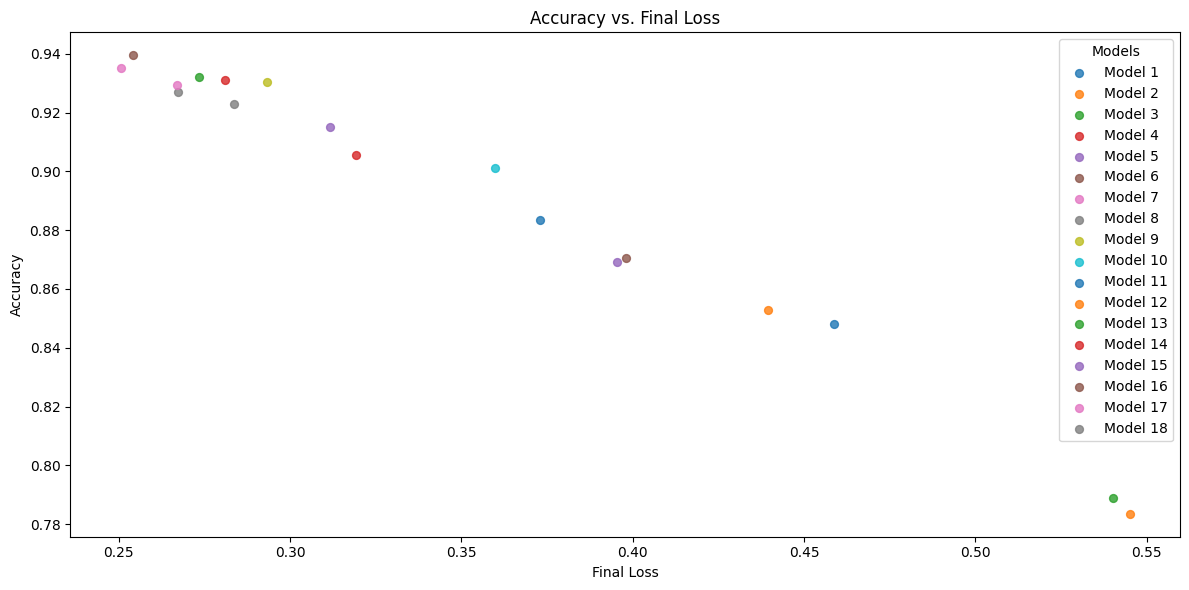

In [44]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
for i, result in enumerate(results):
    final_loss = results_df.loc[i, 'final_loss']  # Get final_loss from results_df
    ax.scatter(final_loss, result['accuracy'], s=32, alpha=.8, label=f"Model {i+1}")

ax.set_xlabel("Final Loss")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. Final Loss")
# Remove this line to keep the box:
# ax.spines[['top', 'right']].set_visible(False)
ax.legend(title="Models", loc="upper right")

plt.tight_layout()
plt.show()

## **Conclusion:**
This experiment investigated the impact of pretraining, batch size and epochs on the performance of a neural network for classifying astronomical objects using the SDSS DR14 dataset. We trained and evaluated models with different batch sizes (32, 64, 128) while keeping other hyperparameters constant.
- The training loss generally decreased over epochs for all batch sizes, indicating that the models were learning from the data. 
- The training accuracy generally increased over epochs for all batch sizes, however with a particular bias towards the smaller batch size models. Where models with smaller batch sizes showed faster initial accuracy improvements, with larger batch sizes catching up later to achieve a similar final accuracy. Meaning the small batch size models are also good performers low epochs.
- Despite slightly lower than expected performance of the pretrained models, they all favour support for lower batch sizes and higher epochs.
- The minimal difference between the performance of our NN and the pretrained models could be due to PyTorch TorchVison's heavy training on images and most common application in object classification of images.
- Despite the trade-offs between convergence speed, stability, and final performance when choosing the optimum batch size and epochs for this specific dataset, a pretrained model with a batch size of **34** to **20** epochs (Model 16) achieves the lowest loss and highest accuracy.
- **Further Investigation:** Further experiments with different learning rates and model architectures could be conducted to refine the optimal batch size and epochs to further improve the model's performance.